## Perturbative footprint study: data creation

### Imports

In [138]:
# Standard imports
import numpy as np
import shutil
from ruamel.yaml import YAML
import os
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from difflib import Differ
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
from matplotlib.backends.backend_pdf import PdfPages

# Cern modules
import fillingpatterns as fp
import xtrack as xt

# Improve style
import matplotlib
import seaborn as sns

sns.set_theme(style="whitegrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=0.8, rc={"lines.linewidth": 0.2, "grid.linewidth": 0.1})


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

%config InlineBackend.figure_format='retina'

### Load my both datasets with croma 15 and 5


In [139]:
# Load dataframe for DA
path = "/afs/cern.ch/work/c/cdroin/private/DA_study/master_study/opt_flathv_75_1500_withBB_chroma15_1p4_all_bunches"
df_c15 = pd.read_parquet(f"{path}/da.parquet")

# Round all numbers to 3 decimals
df_c15 = df_c15.round(3)

# Get list of bunches and list of DA
s_bunch_nb_c15 = df_c15["bunch_nb"]
s_DA_c15 = df_c15["normalized amplitude in xy-plane"]

In [140]:
# Load Sofia's data (chroma 5)
df_c5 = pd.read_parquet('data_Sofia/daEOL_withBB_chroma5_filling.parquet')

# Round all numbers to 3 decimals
df_c5 = df_c5.round(3)

# Get list of bunches and list of DA
s_bunch_nb_c5 = df_c5["bunch_nb"]
s_DA_c5 = df_c5["normalized amplitude in xy-plane"]


In [141]:
# Ensure machine configs are the same
with open('/afs/cern.ch/work/c/cdroin/private/DA_study/master_study/opt_flathv_75_1500_withBB_chroma15_1p4_all_bunches/madx_000/config.yaml') as file_1, open('/afs/cern.ch/work/s/skostogl/public/forColas/bbb_DA/opt_flathv_75_1500_withBB_chroma5_filling/madx_000/config.yaml') as file_2:
    differ = Differ()
    for line in differ.compare(file_1.readlines(), file_2.readlines()):
        print(line)

  # Links to be made for tools and scripts

  links:

    tracking_tools: auto

    modules: tracking_tools/lhcmask

    tools: tracking_tools/lhctoolkit

    #beambeam_macros: tracking_tools/beambeam_macros

    errors: tracking_tools/lhcerrors

    optics_repository: /afs/cern.ch/eng/lhc/optics

  

  # Mode - choose between:

  

  #    Main modes:

  #    'b1_without_bb'

  #    'b1_with_bb'

  #    'b4_from_b2_without_bb'

  #    'b4_from_b2_with_bb'

  

  #    Legacy modes

  #     'b1_with_bb_legacy_macros

  #     'b4_without_bb'

  

  mode: b1_with_bb

  

- # For test against madx mask for modes

+ # For test against madx mask for modes 

?                                       +

  # 'b4_from_b2_without_bb' and 'b4_without_bb':

  # force_leveling:

  #       on_sep8: -0.03425547139366354

  #       on_sep2: 0.14471680504084292

  

  # Optics file

+ #optics_file: optics_repository/hllhc15/flat/opt_flatvh_75_300_1500_thin.madx

  optics_file: optics_repository/HLLHCV1.5/f

### Look for bunch in common, and compute correlation

In [142]:
l_idx_to_keep = [i for i, bunch_nb in enumerate(s_bunch_nb_c15) if bunch_nb in s_bunch_nb_c5.values]

# Keep only bunches in common
s_DA_c15 = [s_DA_c15[i] for i in l_idx_to_keep]
s_bunch_nb_c15 = [s_bunch_nb_c15[i] for i in l_idx_to_keep]

# Assert list of bunches are identical now
assert all(s_bunch_nb_c15) == all(s_bunch_nb_c5)

In [166]:
# create a PdfPages object #! Don't forget to close it at the end of the script!
pdf = PdfPages('PDF_output/survival_chromas.pdf')

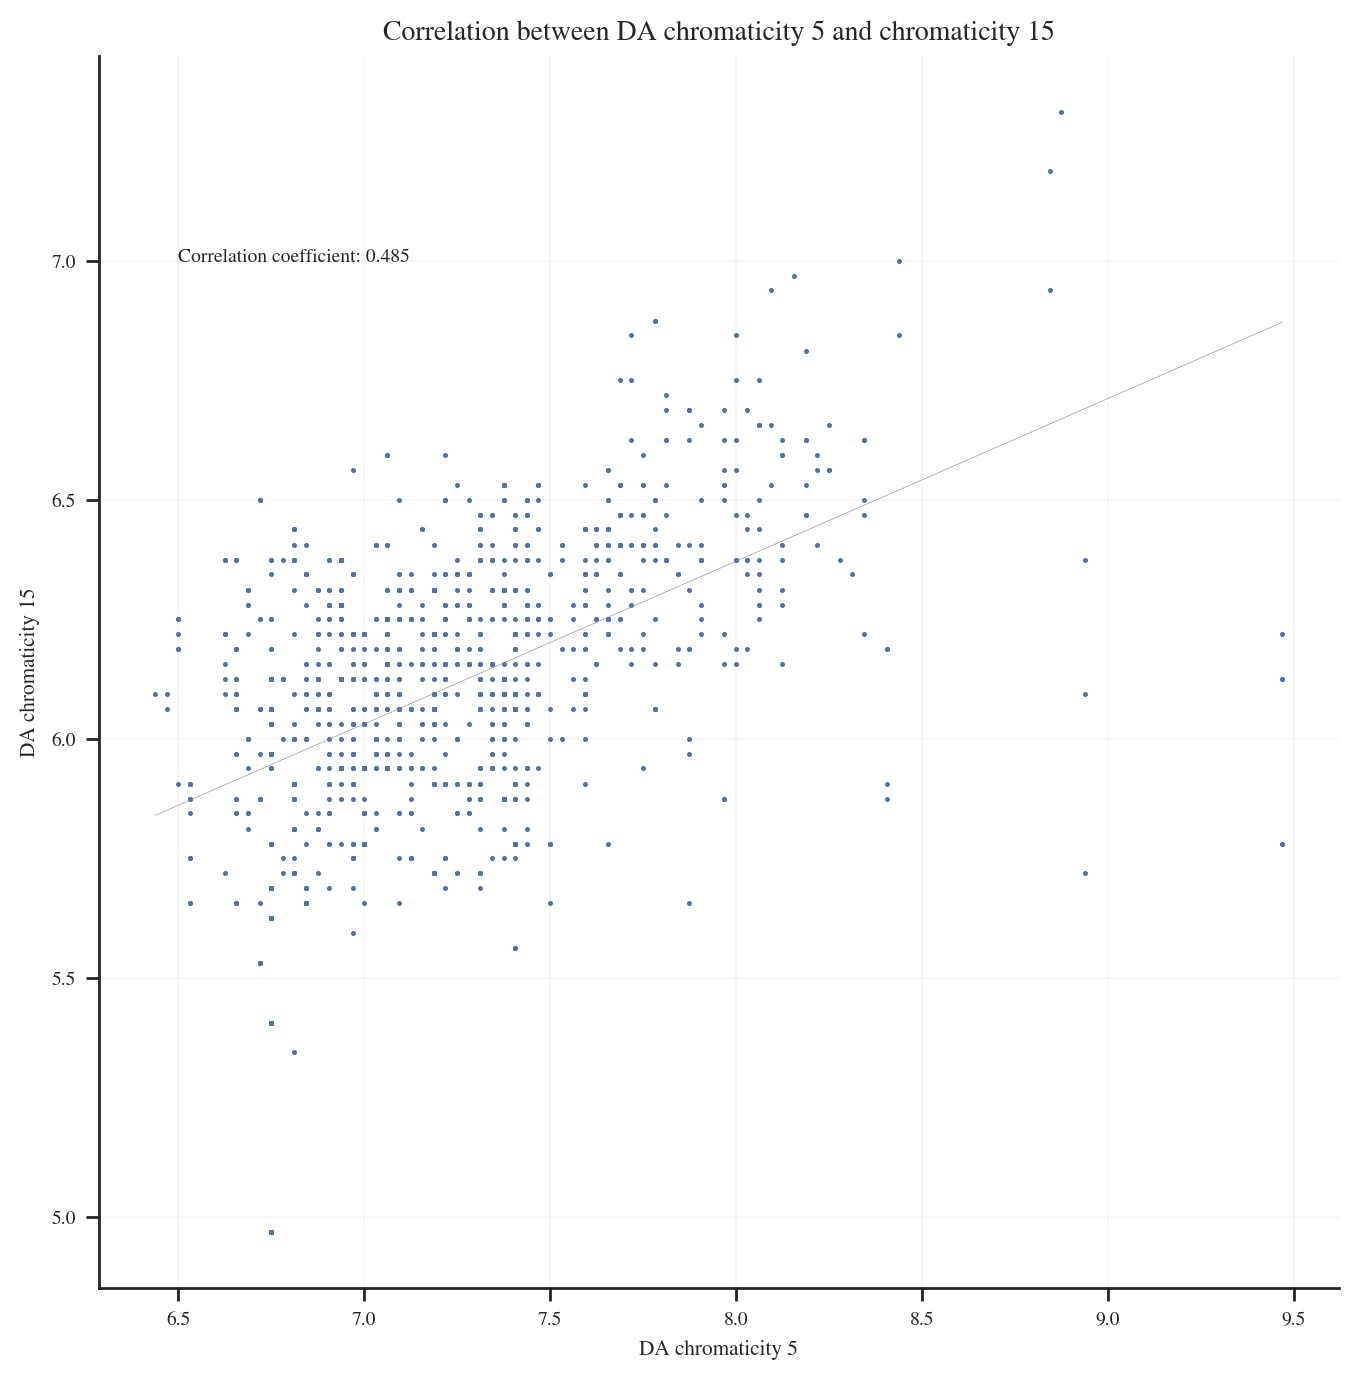

In [167]:

# Plot correlation between DA for chroma 5 and chroma 15
fig = plt.figure(figsize=(8, 8))
plt.scatter(s_DA_c5, s_DA_c15, s=1)
# Plot regression line
plt.plot(
    np.unique(s_DA_c5),
    np.poly1d(np.polyfit(s_DA_c5, s_DA_c15, 1))(np.unique(s_DA_c5)),
    color="grey",
)
# Write correlation coefficient
plt.text(6.5, 7, f"Correlation coefficient: {np.corrcoef(s_DA_c5, s_DA_c15)[0, 1]:.3f}", fontsize=7)
plt.grid()
plt.xlabel("DA chromaticity 5")
plt.ylabel("DA chromaticity 15")
plt.title("Correlation between DA chromaticity 5 and chromaticity 15", fontsize = 10)
plt.show()
# save the current figure
pdf.savefig(fig)
plt.close()

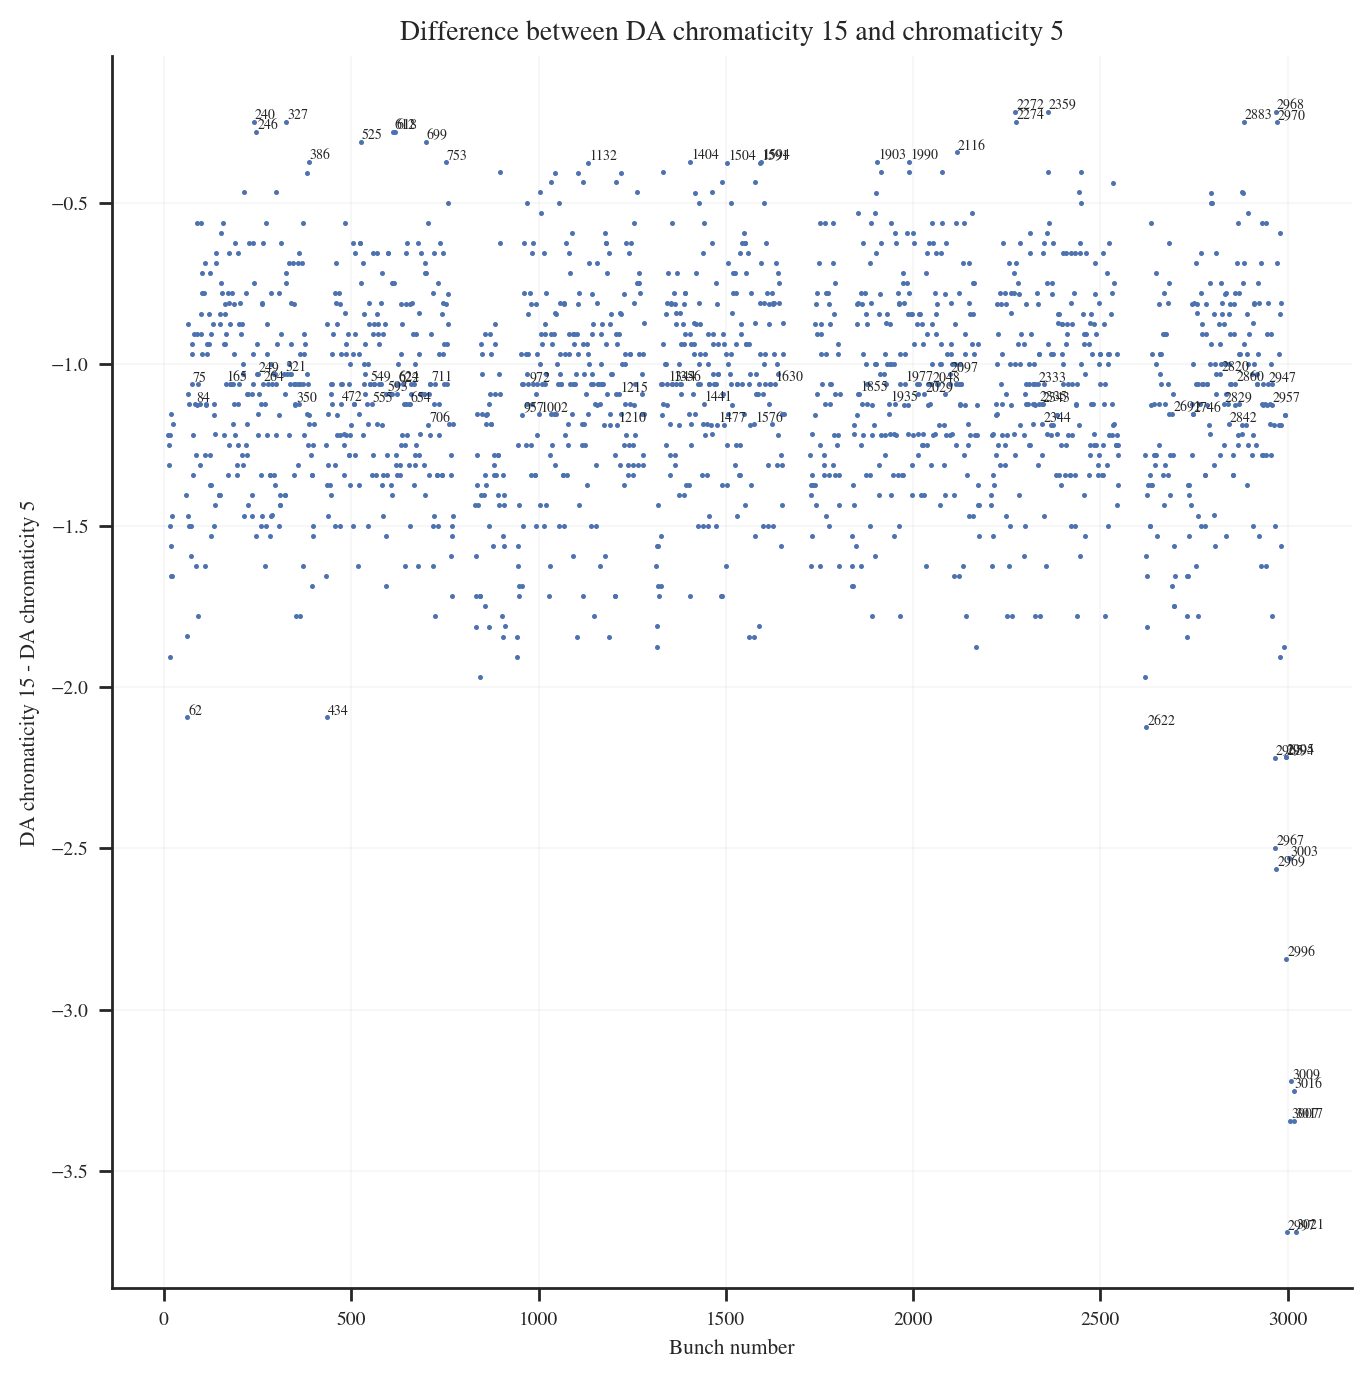

In [168]:
# Plot the difference between DA chroma 5 and chroma 15, with bunch number for the outliers
fig = plt.figure(figsize=(8, 8))
plt.scatter(s_bunch_nb_c15, np.array(s_DA_c15) - np.array(s_DA_c5), s=1)
# Labels the bunches with the largest difference
for i, (bunch_nb, diff) in enumerate(zip(s_bunch_nb_c15, np.array(s_DA_c15) - np.array(s_DA_c5))):
    if abs(diff) < 0.4 or abs(diff) > 2:
        plt.text(bunch_nb+3, diff+0.01, f"{int(bunch_nb)}", fontsize=5)
    # Add randomly with probablity 0.1 a few bunch labels with average difference
    if abs(diff)>1 and abs(diff)<1.2:
        if np.random.random() < 0.1:
            plt.text(bunch_nb+3, diff+0.01, f"{int(bunch_nb)}", fontsize=5)

plt.grid()
plt.xlabel("Bunch number")
plt.ylabel("DA chromaticity 15 - DA chromaticity 5")
plt.title("Difference between DA chromaticity 15 and chromaticity 5", fontsize = 10)
plt.show()
# save the current figure
pdf.savefig(fig)
plt.close()


### Get data for survival analysis

In [146]:
# Build dataframe of initial distribution
path = "/afs/cern.ch/work/c/cdroin/private/DA_study/master_study/opt_flathv_75_1500_withBB_chroma15_1p4_all_bunches/particles"
df_initial_distribution = pd.DataFrame()
for name in os.listdir(path):
    if name.endswith('.parquet'):
        df_initial_distribution = pd.concat([df_initial_distribution, pd.read_parquet(f'{path}/{name}')], ignore_index=False)
df_initial_distribution

,particle_id,normalized amplitude in xy-plane,angle in xy-plane [deg]
0,0.0,2.00000,15.0
1,1.0,2.00000,30.0
2,2.0,2.00000,45.0
3,3.0,2.00000,60.0
4,4.0,2.00000,75.0
...,...,...,...
123,1275.0,9.96875,15.0
124,1276.0,9.96875,30.0
125,1277.0,9.96875,45.0
126,1278.0,9.96875,60.0


In [35]:
# List all bunch folders and build a dictionnary containing the corresponding survival rate for each particle in each bunch
path_c15 = "/afs/cern.ch/work/c/cdroin/private/DA_study/master_study/opt_flathv_75_1500_withBB_chroma15_1p4_all_bunches"
path_c5 = "/afs/cern.ch/work/s/skostogl/public/forColas/bbb_DA/opt_flathv_75_1500_withBB_chroma5_filling"
l_d_bunch_survival = []
for path, df in zip([path_c15, path_c5], [df_c15, df_c5]):
    d_bunch_survival = {}
    for name, bunch_nb in zip(df.index, df["bunch_nb"]):
        if name in os.listdir(path):
            path_part = path + '/' + name 
            # Find all folders (particles) starting with xsuite and merge the corresponding dataframes
            #df_input_particle = pd.DataFrame()
            df_output_particle = pd.DataFrame()
            for folder in os.listdir(path_part):
                if folder.startswith('xsuite') and not folder.endswith('lines'):
                    #df_input_particle = pd.concat([df_input_particle, pd.read_parquet(f'{path_part}/{folder}/input_particles.parquet')], ignore_index=False)
                    df_output_particle = pd.concat([df_output_particle, pd.read_parquet(f'{path_part}/{folder}/output_particles.parquet')], ignore_index=False)
            # Get the corresponding number of turns for each particle and DA retained
            df_output_particle = df_output_particle[['particle_id','at_turn']]

            # Merge with initial distribution
            df_output_particle = df_output_particle.merge(df_initial_distribution, on='particle_id', how='left')
            d_bunch_survival[int(bunch_nb)] = df_output_particle
    l_d_bunch_survival.append(d_bunch_survival)
    break
        

### Check survival plot for a few selected bunches

In [147]:
# First check bunches that are very similar in both chrom conditions
l_similar_bunches = [525, 1132]
l_different_bunches = [2622, 3009]
l_normal_bunches = [210, 756]

In [169]:
def plot_survival(dic_bunch_survival, bunch_nb, subtitle = ''):
    # Build coordinates in x and y
    amplitude = dic_bunch_survival["normalized amplitude in xy-plane"].to_numpy()
    phase = dic_bunch_survival["angle in xy-plane [deg]"].to_numpy()
    x = amplitude * np.cos(phase * np.pi / 180)
    y = amplitude * np.sin(phase * np.pi / 180)
    survival = dic_bunch_survival["at_turn"].to_numpy()

    # Map survival to color
    cmap = sns.color_palette("Spectral", as_cmap=True)

    # Add transparency to colormap
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:, -1] = 0.9
    cmap = ListedColormap(my_cmap)

    # Finish mappingÒ
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1e6)
    colors = cmap(norm(survival))

    # Survival plot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(subtitle)
    ax.set_xlabel(r"$x [\sigma]$")
    ax.set_ylabel(r"$y [\sigma]$")
    # Plot points
    ax.scatter(x, y, c=colors, s=1, alpha=0.5)

    # Plot DA, that is, the amplitude of the particle with the survival different from 1000000
    amplitude = amplitude[survival != 1000000]
    survival = survival[survival != 1000000]
    DA = np.min(amplitude)
    # Plot a circle with radius DA
    circle = plt.Circle((0, 0), DA, color="grey", fill=False, linewidth=0.5, linestyle="--")
    ax.add_artist(circle)
    plt.text(s ="DA", fontsize=5, x=0.1, y=DA + 0.1)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)

    # For nicer formatting of colorbar ticks
    def fmt(x, pos):
        a, b = '{:.0e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=ax, fraction=0.036, pad=0.04, format=ticker.FuncFormatter(fmt), ticks=np.linspace(0, 1000000, 6))
    cb.ax.set_ylabel('Number of turns before losing particle', rotation=270, labelpad=15, fontsize=7)
    cb.outline.set_visible(False)
    cb.ax.tick_params(labelsize=5,length=2, width=0.4, which="major")
    ax.set_aspect("equal")
    ax.grid()
    plt.suptitle("Survival plot for bunch " + str(bunch_nb) + " with chromaticity 15" + ", DA = " + str(DA), y=0.96)
    plt.tight_layout()
    plt.show()
    # save the current figure
    pdf.savefig(fig)
    plt.close()

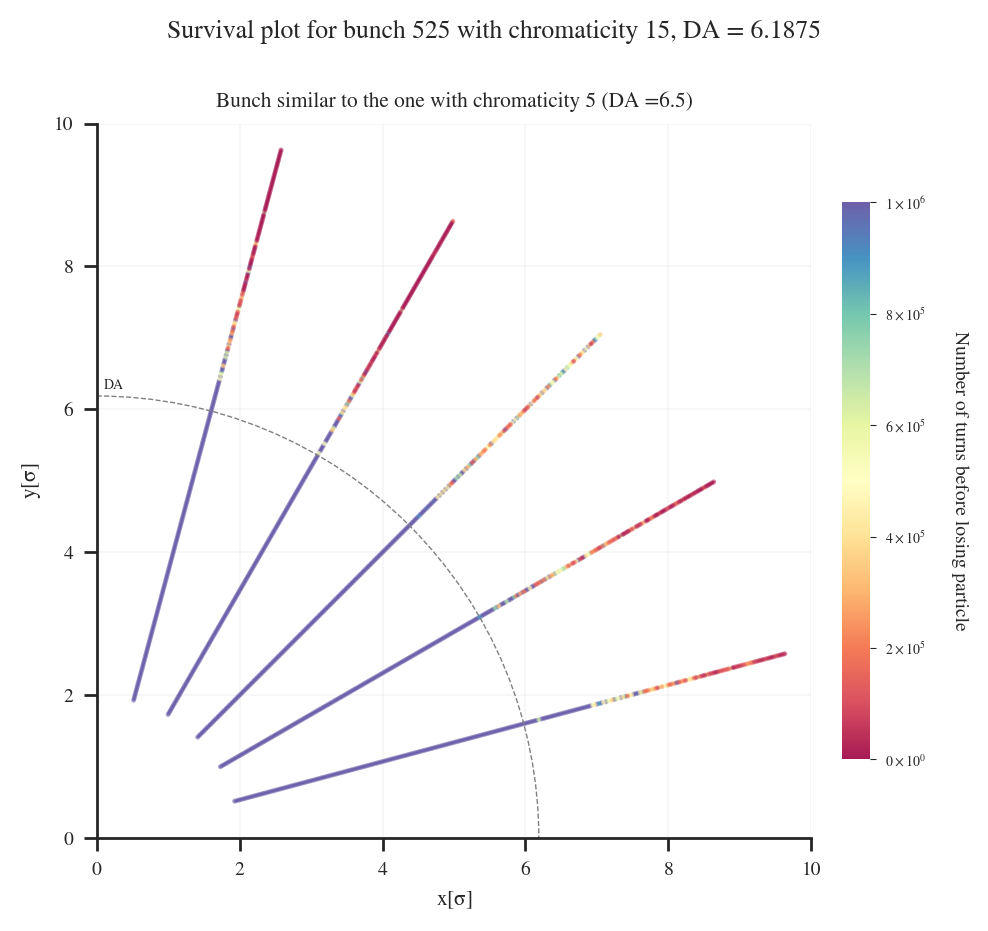

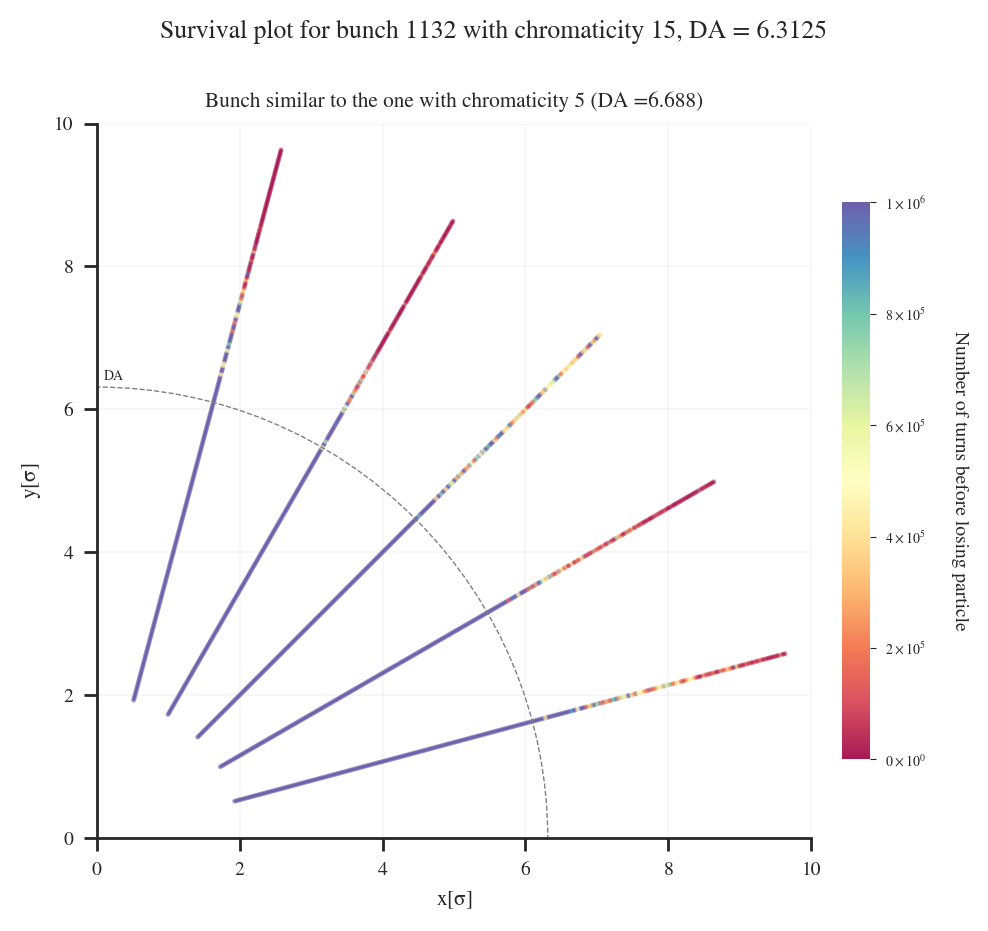

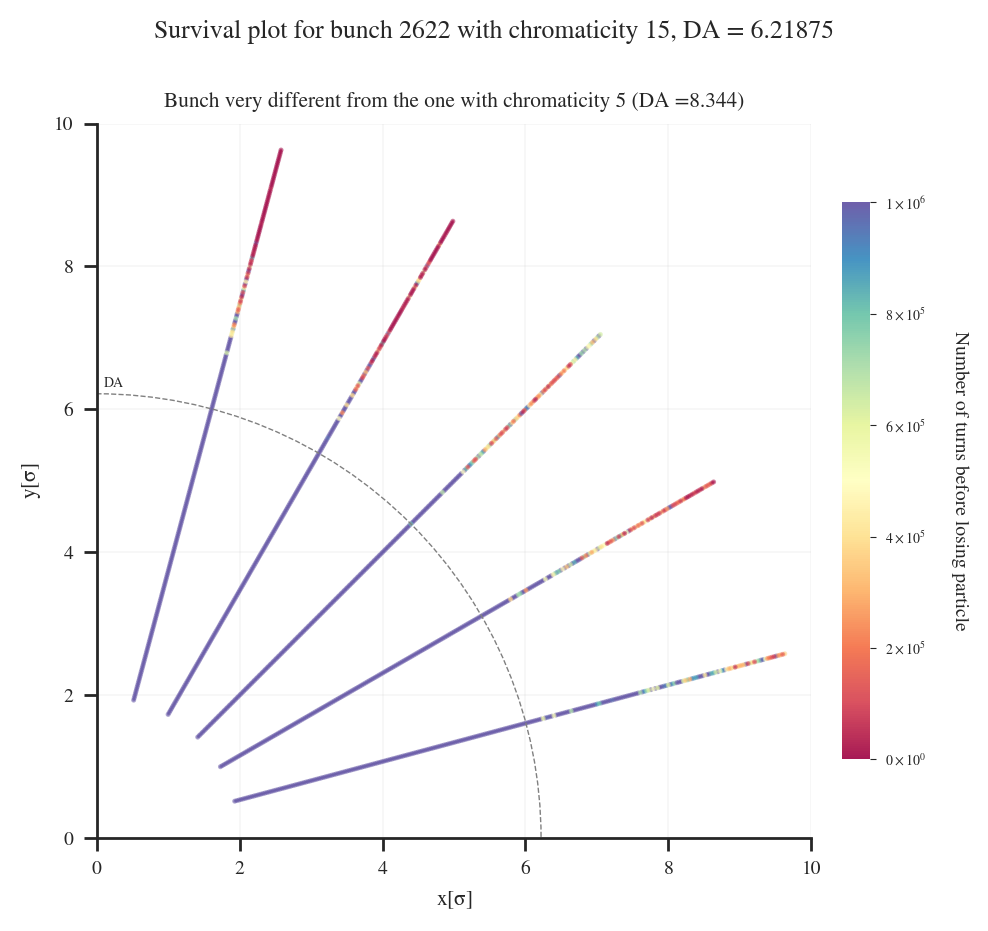

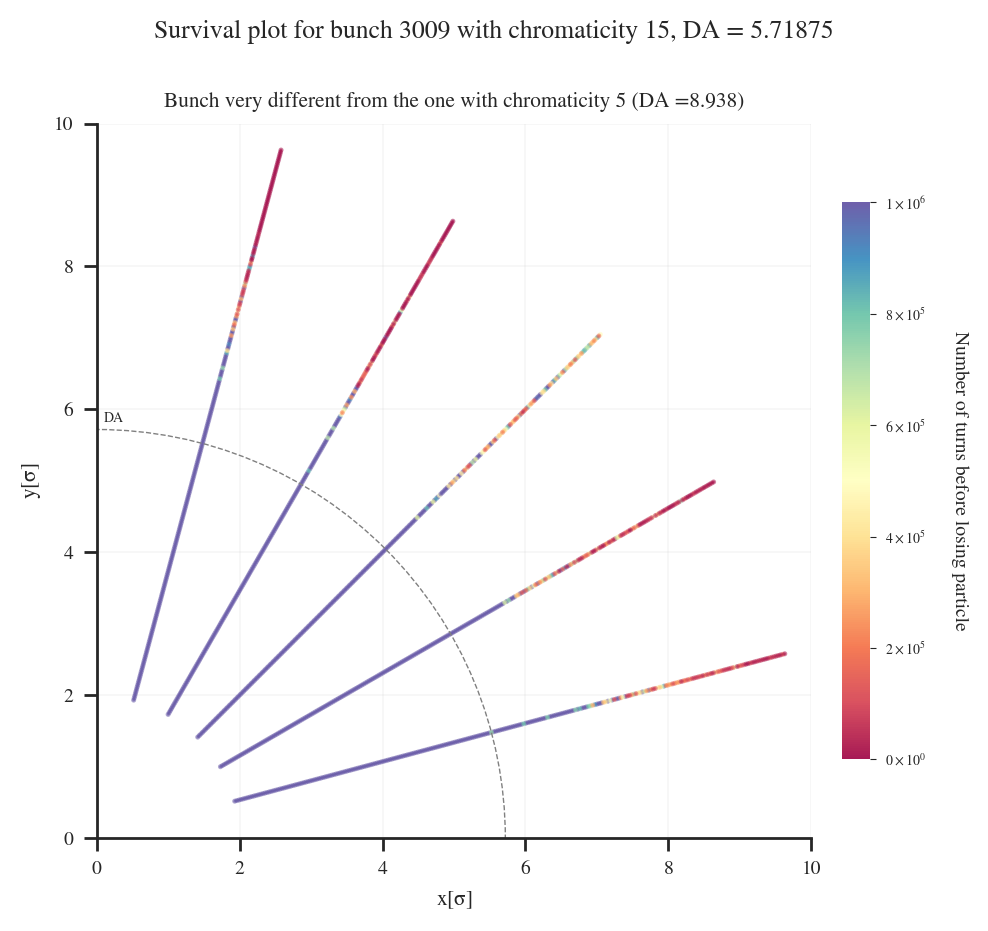

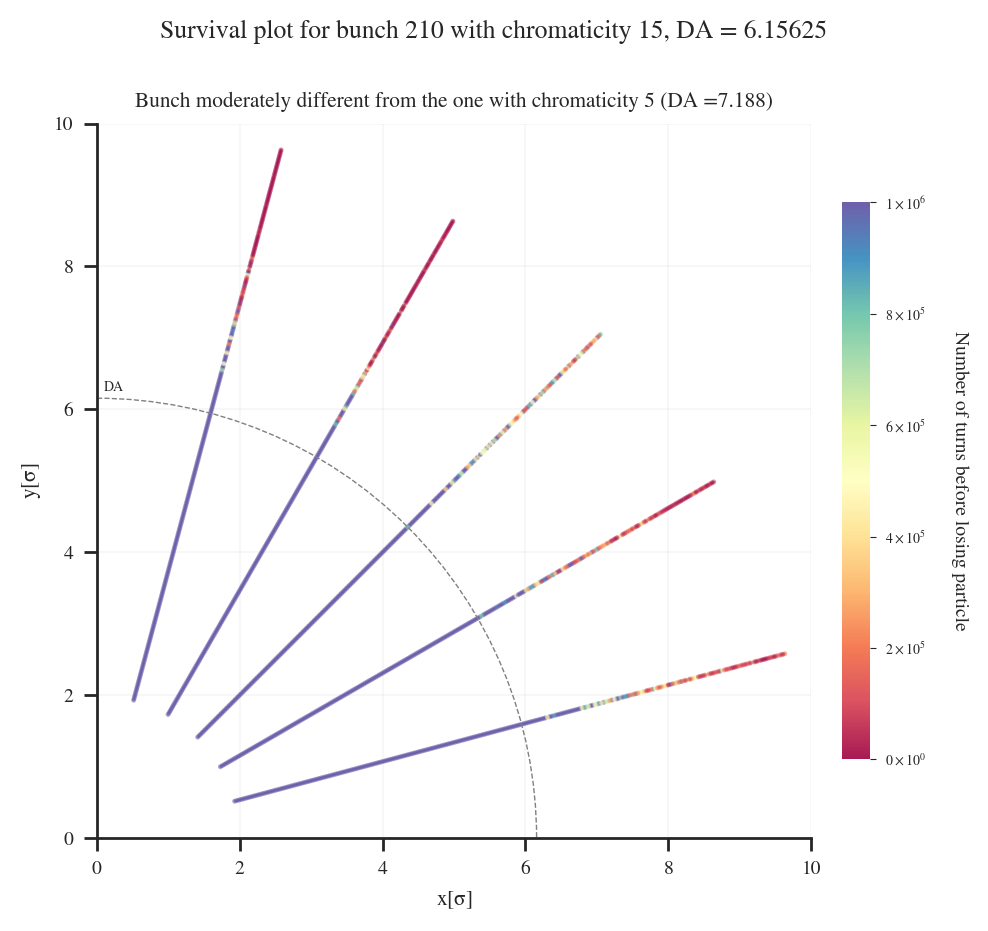

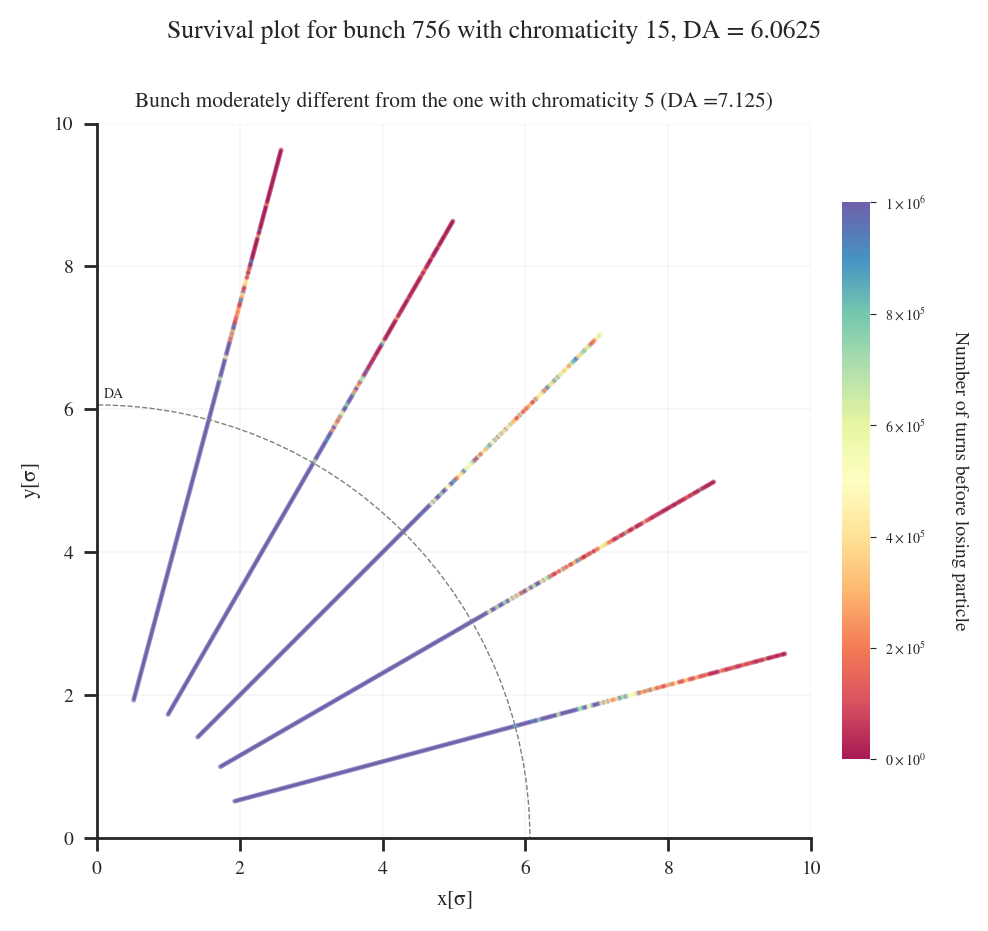

In [170]:
for l_bunch, type_bunch in zip(
    [l_similar_bunches, l_different_bunches, l_normal_bunches],
    [
        "Bunch similar to the one with chromaticity 5",
        "Bunch very different from the one with chromaticity 5",
        "Bunch moderately different from the one with chromaticity 5",
    ],
):
    for bunch_nb in l_bunch:
        DA_c5 = df_c5[df_c5.bunch_nb == bunch_nb]["normalized amplitude in xy-plane"].values[0]
        type_bunch_annot = type_bunch + f" (DA ={DA_c5})"
        plot_survival(l_d_bunch_survival[0][bunch_nb], bunch_nb, subtitle=type_bunch_annot)

In [171]:
# Close the pdf file
pdf.close()